# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Импортируем необходимые библиотеки

In [125]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

## Откройте и изучите файл

In [126]:
#импортируем данные
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    print('Ошибка. Проверьте правильность пути к данным')
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Проведем корреляционный анализ.

In [128]:
corrMatrix = df.corr()

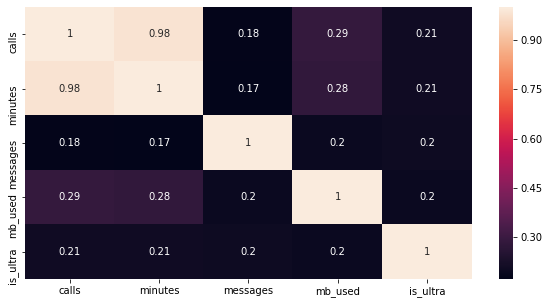

In [129]:
#Построим корреляционную матрицу
plt.figure(figsize=(10, 5))
sn.heatmap(corrMatrix, annot=True)
plt.show()

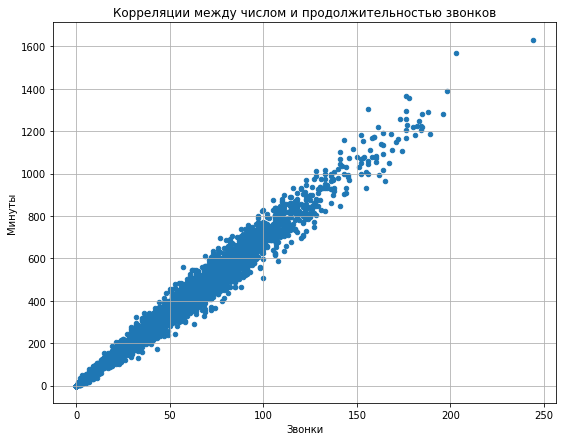

In [130]:
df.plot(x='calls', y='minutes', kind='scatter', figsize=(9, 7), grid=True) 
plt.title("Корреляции между числом и продолжительностью звонков")
plt.ylabel("Минуты")
plt.xlabel("Звонки")
plt.show()

Коэффициент корреляции между количеством и продолжительностью звонков равен 0.98. В этом случае мы можем не учитывать данные о количестве звонков для построения моделей.

In [131]:
#уберем столбец о звонках
df.drop(['calls'], axis='columns',  inplace=True)

Вывод: Предобработка данных выполнена. Пропусков нет. Можно приступать к моделям.

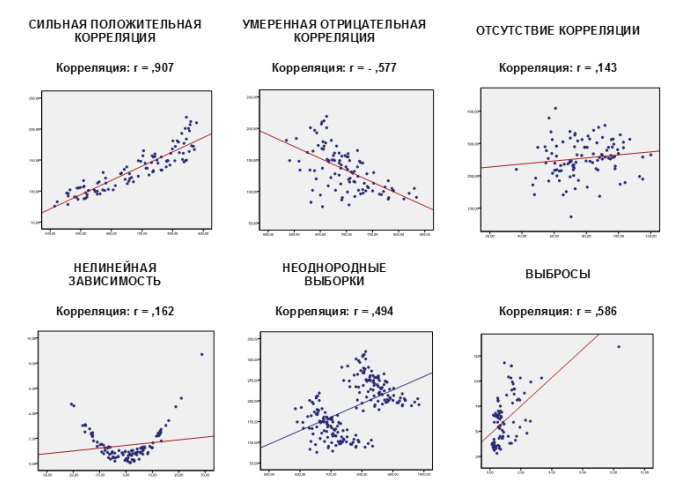

## Разбейте данные на выборки

Разобьём датасет на три выборки: тренировочная, тестовая и валидационная в пропрорциях 50/25/25.

In [132]:
df_train, df_rest = train_test_split(df, test_size=0.5, random_state=12345)
df_test, df_valid = train_test_split(df_rest, test_size=0.5, random_state=12345)

In [133]:
#размер тренировочной выборки
df_train.shape

(1607, 4)

In [134]:
#размер тестовой выборки
df_test.shape

(803, 4)

In [135]:
#размер валидационной выборки
df_valid.shape

(804, 4)

Определим признаки и целевой признак для всех выборок. Целевым признаком будет являться значение столбца "is_ultra"

In [136]:
#для тренировочной
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

In [137]:
#для тестовой
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [138]:
#для валидационной
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

In [139]:
1607+803+804

3214

## Исследуйте модели

Обучим модель "Дерево решений" и определим параметр глубины(depth) при котором модель выдает лучший результат.

In [140]:
accur=0
dep=0
for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model_tree.fit(features_train, target_train) 
    predictions = model_tree.predict(features_valid) 
    accuracy = accuracy_score(target_valid, predictions)
    if accuracy > accur:
        accur=accuracy
        dep=depth
print('Параметры наилучшей модели на валидационной выборке: ' "depth=", dep, "accuracy:", accur)

Параметры наилучшей модели на валидационной выборке: depth= 4 accuracy: 0.7997512437810945


Вывод: Лучший результат показывает модель с параметром depth =4, точность её предсказаний 80%.

Обучим модель "Случайный лес" и определим параметры n_estimators и depth при котором модель выдает лучший результат.

In [141]:
accur=0
est=0
dep=0
#Попробовал разные диапазоны. При увелечение диапазона точность почти не меняется, зато время загрузки увеличивается сильно, 
#поэтому остановился на таких параметрах.
for estim in range(1, 20, 2): 
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions = model_forest.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)
        if accuracy > accur:
            accur=accuracy
            est=estim
            dep=depth
print('Параметры наилучшей модели на валидационной выборке: ' "n_estimators=", est, "depth=", dep,"accuracy:", accur)

Параметры наилучшей модели на валидационной выборке: n_estimators= 13 depth= 8 accuracy: 0.8171641791044776


Вывод: Лучший результат показывает модель с параметрами n_estimators= 13 и depth= 8, точность её предсказаний 82%.

Обучим модель "Логическая регрессия".

In [142]:
model_logreg = LogisticRegression(random_state=12345)
model_logreg.fit(features_train, target_train)
predictions = model_logreg.predict(features_valid) 
accuracy = accuracy_score(target_valid, predictions)
print("Accuracy модели логистической регрессии на валидационной выборке:", accuracy)

Accuracy модели логистической регрессии на валидационной выборке: 0.7263681592039801


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Вывод: модель "Логическая регрессия" не имеет дополнительных параметров, но и работает гораздо быстрее остальных. Точность предсказания 72%.

Общий вывод: Лучшее показатели у модели "Случайный лес", но она же является самой медленной в плане скорости обработки данных.

## Проверьте модель на тестовой выборке

Проверим модель на тестовой выборке с помощью "Дерева решиний".

In [143]:
model_tree_test = DecisionTreeClassifier(random_state=12345, max_depth=4) 
model_tree_test.fit(features_train, target_train) 
predictions = model_tree_test.predict(features_test) 
accuracy = accuracy_score(target_test, predictions)
print('accuracy модели на тестовой выборке:', accuracy)

accuracy модели на тестовой выборке: 0.7820672478206725


Проверим модель на тестовой выборке с помощью "Случайного леса".

In [144]:
model_forest_test = RandomForestClassifier(random_state=12345, n_estimators=13, max_depth=8)
model_forest_test.fit(features_train, target_train)
predictions = model_forest_test.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('accuracy модели на тестовой выборке:', accuracy)

accuracy модели на тестовой выборке: 0.7907845579078456


Проверим модель на тестовой выборке с помощью "Логической регрессии'.

In [145]:
model_logreg_test = LogisticRegression(random_state=12345)
model_logreg_test.fit(features_train, target_train)
predictions = model_logreg_test.predict(features_test) 
accuracy = accuracy_score(target_test, predictions)
print('accuracy модели на тестовой выборке:', accuracy)

accuracy модели на тестовой выборке: 0.7247820672478207


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Вывод: На тестовой выборке точность всех моделей немного снизилась, но в целом распределение точностей осталось таким-же. Самая точная модель Случайный лес, самая неточная Логическая регрессия.

## (бонус) Проверьте модели на адекватность

Проверим модель на адекватность с помощью DummyClassifier

In [146]:
dummy = DummyClassifier(strategy="most_frequent", random_state=0)
dummy.fit(features_train, target_train)
dummy.score(features_train, target_train)

0.6770379589296827

Тест на адекватность проеден. DummyClassifier показывает результаты хуже, чем все остальные, обученные мной модели. 